In [24]:
# import necessary packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

## Import: Terry Stops

In [25]:
# import Terry_Stops.csv

df_ts = pd.read_csv('data/Terry_Stops.csv')
df_ts.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [26]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47297 entries, 0 to 47296
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47297 non-null  object
 1   Subject ID                47297 non-null  int64 
 2   GO / SC Num               47297 non-null  int64 
 3   Terry Stop ID             47297 non-null  int64 
 4   Stop Resolution           47297 non-null  object
 5   Weapon Type               47297 non-null  object
 6   Officer ID                47297 non-null  object
 7   Officer YOB               47297 non-null  int64 
 8   Officer Gender            47297 non-null  object
 9   Officer Race              47297 non-null  object
 10  Subject Perceived Race    47297 non-null  object
 11  Subject Perceived Gender  47297 non-null  object
 12  Reported Date             47297 non-null  object
 13  Reported Time             47297 non-null  object
 14  Initial Call Type     

## Clean Data

1. Drop null values
2. Simplify relevant columns

In [27]:
# delete column with null values

df_ts.drop(columns=["Officer Squad"], inplace=True)

In [28]:
df_ts.isna().sum() #if we get a result: df_ts.dropna(inplace=True)

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

Simplify relevant columns

We determined the column 'Stop Resolution' to be the best way to determine if a Terry Stop resulted in an outcome that could be considered significant or life-altering.

After research, we concluded that 'Field Contact' and 'Citation / Infraction' represented x% of results within the column and could also be considered insignificant. In comparison, 'Offense Report', 'Arrest', and 'Referred for Prosecution' represented x% of data and each represent a life-altering outcome for the individual stopped.

In [29]:
df_ts["Stop Resolution"].value_counts()

Field Contact               19048
Offense Report              15657
Arrest                      11685
Referred for Prosecution      728
Citation / Infraction         179
Name: Stop Resolution, dtype: int64

In [30]:
df_ts["Stop Resolution"].value_counts().to_dict()

{'Field Contact': 19048,
 'Offense Report': 15657,
 'Arrest': 11685,
 'Referred for Prosecution': 728,
 'Citation / Infraction': 179}

In [31]:
# map to column

df_ts['Stop Resolution'] = df_ts['Stop Resolution'].map({'Field Contact': 0,
                                                   'Offense Report': 1,
                                                   'Arrest': 1,
                                                   'Referred for Prosecution': 1,
                                                   'Citation / Infraction': 0})


In [32]:
# Classification, dealing with null values
# Train test
# Data cleaning
# Convert training data to numeric information
# FSM - first simple model (throw data in and see if it works)

In [33]:
df_ts['Weapon Type'].value_counts()

None                                    32565
-                                       11935
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         636
Handgun                                   291
Firearm Other                             100
Blunt Object/Striking Implement            86
Club, Blackjack, Brass Knuckles            49
Firearm                                    38
Mace/Pepper Spray                          28
Other Firearm                              23
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        9
Rifle                                       7
Fire/Incendiary Device                      7
None/Not Applicable                         7
Shotgun                                     3
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Brass Knuckles                              1
Blackjack                         

In [34]:
df_ts["Weapon Type"].value_counts().to_dict()

{'None': 32565,
 '-': 11935,
 'Lethal Cutting Instrument': 1482,
 'Knife/Cutting/Stabbing Instrument': 636,
 'Handgun': 291,
 'Firearm Other': 100,
 'Blunt Object/Striking Implement': 86,
 'Club, Blackjack, Brass Knuckles': 49,
 'Firearm': 38,
 'Mace/Pepper Spray': 28,
 'Other Firearm': 23,
 'Firearm (unk type)': 15,
 'Taser/Stun Gun': 10,
 'Club': 9,
 'Rifle': 7,
 'Fire/Incendiary Device': 7,
 'None/Not Applicable': 7,
 'Shotgun': 3,
 'Personal Weapons (hands, feet, etc.)': 2,
 'Automatic Handgun': 2,
 'Brass Knuckles': 1,
 'Blackjack': 1}

In [35]:
df_ts['Weapon Type'] = df_ts['Weapon Type'].map({'None': 'NA',
                                           '-': 'NA',
                                           'Lethal Cutting Instrument': 'Non-Firearm',
                                           'Knife/Cutting/Stabbing Instrument': 'Non-Firearm',
                                           'Handgun': 'Firearm',
                                           'Firearm Other': 'Firearm',
                                           'Blunt Object/Striking Implement': 'Non-Firearm',
                                           'Club, Blackjack, Brass Knuckles': 'Non-Firearm',
                                           'Firearm': 'Firearm',
                                           'Mace/Pepper Spray': 'Non-Firearm',
                                           'Other Firearm': 'Firearm',
                                           'Firearm (unk type)': 'Firearm',
                                           'Taser/Stun Gun': 'Non-Firearm',
                                           'Club': 'Non-Firearm',
                                           'Fire/Incendiary Device': 'Non-Firearm',
                                           'None/Not Applicable': 'NA',
                                           'Rifle': 'Firearm',
                                           'Shotgun': 'Firearm',
                                           'Personal Weapons (hands, feet, etc.)': 'Non-Firearm',
                                           'Automatic Handgun': 'Firearm',
                                           'Blackjack': 'Non-Firearm',
                                           'Brass Knuckles': 'Non-Firearm'})

In [36]:
# change column datatypes

In [37]:
# potentially create new dataframe with only relevant columns

# relevant_cols = df_ts[['Arrest Flag','Weapon Type','Frisk Flag','Precinct','Officer Gender','Subject Perceived Gender','Subject Perceived Race']]

In [38]:
# how else do we need to modify these columns: 'Weapon Type','Frisk Flag','Precinct','Officer Gender','Subject Perceived Gender','Subject Perceived Race'

In [39]:
df_ts.drop(columns=['Subject Age Group','Subject ID','GO / SC Num','Terry Stop ID','Officer ID','Officer YOB','Officer Race',
                'Reported Date','Reported Time','Initial Call Type','Final Call Type','Arrest Flag','Call Type','Sector','Beat'], axis=1, inplace=True)

In [40]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47297 entries, 0 to 47296
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Stop Resolution           47297 non-null  int64 
 1   Weapon Type               47297 non-null  object
 2   Officer Gender            47297 non-null  object
 3   Subject Perceived Race    47297 non-null  object
 4   Subject Perceived Gender  47297 non-null  object
 5   Frisk Flag                47297 non-null  object
 6   Precinct                  47297 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.5+ MB


## Train Test Split

In [41]:
X = df_ts.loc[:, ['Weapon Type','Frisk Flag','Precinct','Officer Gender','Subject Perceived Gender',
                  'Subject Perceived Race']]
y = df_ts.loc[:, 'Stop Resolution'] #see Smote

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [42]:
# use ohe on training data
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

# create dataframe with training and testing data
ohe_df1 = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df2 = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test.columns))
ohe_df = pd.concat([ohe_df1,ohe_df2])

## Create Logistic Regression Model

In [43]:
lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict(X_test_ohe)

# accuracy check - (tp + tn) / (p + n)
display('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# precision - tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

# recall - tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

# f1 - 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

# classification report
# display(classification_report(y_test, y_pred))

# true test is confusion matrix due to 0 across, now that's changed once target did



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


'Logistic Regression Accuracy: '

78.61874559548978

'%'

Precision: 0.748813
Recall: 0.960029
F1 score: 0.841368


## Iterate on Logistic Regression Model

In [ ]:
c_accuracy = {}

kf = KFold(n_splits=4)
cs = np.linspace(1,11,100)

for c in cs:
    
    mean_accuracy = []
    
    for train_ind, val_ind in kf.split(X_train, y_train):
        
        X_tt, y_tt = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
        
        ss = StandardScaler()
        
        X_tt = ss.fit_transform(X_tt)
        X_val = ss.transform(X_val)
        
        log_reg = LogisticRegression(C=c, solver='lbfgs', max_iter=400)
        
        log_reg.fit(X_tt, y_tt)
        
        mean_accuracy.append(log_reg.score(X_val, y_val))

    c_accuracy[c] = np.mean(mean_accuracy)

In [ ]:
sorted(c_accuracy.items(), key=lambda kv: kv[1], reverse=True)[:10]

In [ ]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
log_reg = LogisticRegression(C=2, solver='lbfgs', max_iter=5000)
log_reg.fit(X_train_sc, y_train)

y_hat = log_reg.predict(X_train_sc)

In [ ]:
fig, ax = plt.subplots()
cm = confusion_matrix(y_train, y_hat)
sns.heatmap(cm, ax=ax, annot=True,  square=True, 
            cbar=False, cmap="coolwarm", fmt='g',
            xticklabels=['B', 'M'],yticklabels=['B', 'M'] )

ax.set_xlabel('Predicted', fontdict={'size': 15})
ax.set_ylabel('True', fontdict={'size': 15})
ax.set_title('Logistic Regression: C2', fontdict={'size': 15})

In [ ]:
lr = LogisticRegression(penalty='l1', C=)
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict(X_test_ohe)



# Change regularization via L1 and downtuning of C (address why re overfitting)

# accuracy check - (tp + tn) / (p + n)
display('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# precision - tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

# recall - tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

# f1 - 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

# classification report
# display(classification_report(y_test, y_pred))

# true test is confusion matrix due to 0 across, now that's changed once target did



## Create Decision Tree Model

In [22]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train_ohe, y_train)
# dt.score(X_train_ohe, y_train), default accuracy

DecisionTreeClassifier(max_depth=5)

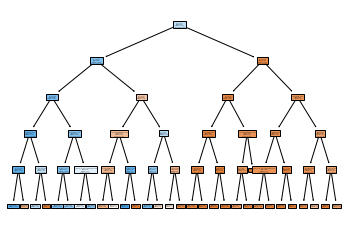

In [23]:
tree.plot_tree(dt, feature_names=ohe.get_feature_names(), filled=True);

In [ ]:
# predict, pass in for F1 score to compare across models
# bring confusion matrix in

In [ ]:
model = build_model(DecisionTreeClassifier(random_state=123), X, y)
model3_results = build_model.results


def build_model(classifier, predictors, labels):
    #Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
    #Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Create variables that can be called outside function
    build_model.X_train = X_train
    build_model.X_test = X_test
    build_model.y_train = y_train
    build_model.y_test = y_test
    
    #Fit model
    model = classifier.fit(X_train, y_train)
    score = np.mean(cross_val_score(classifier, X, y, cv=5, scoring='recall'))
    
    #Create predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)